In [1]:
# Installation des packages
# !pip install numpy pandas matplotlib scikit-learn scipy seaborn
print('Done')

Done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pformat

# Prétraitement des données
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Modèles
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Évaluation des modèles
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from scipy.stats import spearmanr

# Validation croisée et recherche de modèle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold


from sklearn.preprocessing import PolynomialFeatures

In [3]:
raw_data_x = pd.read_csv("data/Data_X.csv", index_col='ID')
raw_dataNew_x = pd.read_csv("data/DataNew_X.csv", index_col='ID')
raw_data_y = pd.read_csv("data/Data_Y.csv", index_col='ID')

In [4]:
data_xy = pd.merge(raw_data_x, raw_data_y, on='ID').copy()

In [5]:
data_fr = data_xy.drop('COUNTRY', axis=1).copy()

In [6]:
X = data_fr.drop('TARGET', axis=1)
y = data_fr['TARGET']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
test_name = 'polynomial 2'
feature_selection = PolynomialFeatures(2)
n = 14

In [9]:
def spearmanr_scorer(y, y_pred):
    try:
        correlation, _ = spearmanr(y, y_pred)
        if np.isfinite(correlation):
            return correlation
        else:
            print("NOT FINITE")
            return 0.0 
    except Exception as e:
        print(f"Error calculating Spearman correlation: {e}")
        return 0.0 

def r2_scorer(y, y_pred):
    return r2_score(y, y_pred)

def rmse_scorer(y, y_pred):
    return mean_squared_error(y, y_pred, squared=False)  # RMSE

r2_scoring = make_scorer(r2_scorer, greater_is_better=True)
rmse_scoring = make_scorer(rmse_scorer, greater_is_better=False)
spearman_scoring = make_scorer(spearmanr_scorer, greater_is_better=True)

scorers = {
    'spearmanr': spearman_scoring,
    'r2': r2_scoring,
    'rmse': rmse_scoring
}
# selection = [PolynomialFeatures(n), SelectKBest(f_regression, k=n)],
selection = [None]

common_params = {
    'imputer': [SimpleImputer()],
    'selection': selection,
    'scaler': [StandardScaler(), RobustScaler()]
}
common_params_tree = {
    'imputer': [SimpleImputer()],
    'selection': selection,
    'scaler': [None]
}

params = {
    'linear': {
        **common_params,
        'imputer__strategy': ['mean', 'median'],
        'model__fit_intercept': [True, False],
    },
    'ridge': {
        **common_params,
        'imputer__strategy': ['mean', 'median'],
        'model__alpha': np.logspace(start=-3, stop=3).tolist()
    },
    'lasso': {
        **common_params,
        'imputer__strategy': ['mean', 'median'],
        'model__alpha': np.logspace(start=-3, stop=3).tolist()
    },
    'knn': {
        **common_params,
        'imputer__strategy': ['mean', 'median'],
        'model__n_neighbors': [1, 3, 8, 15],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'decision_tree': {
        **common_params_tree,
        'imputer__strategy': ['mean', 'median'],
        'model__max_depth': [3, 6, 9],
        'model__min_samples_split': [3, 8],
        'model__min_samples_leaf': [3, 7],
    },
    'random_forest': {
        **common_params_tree,
        'imputer__strategy': ['mean', 'median'],
        'model__n_estimators': [10, 20],  
        'model__max_depth': [None, 3],  
    }
}



pipelines = {
    'linear': Pipeline([
        ('imputer', None),
        ('selection', None), 
        ('scaler', None),
        ('model', LinearRegression())
    ]),
    'ridge': Pipeline([
        ('imputer', None),
        ('selection', None),
        ('scaler', None),
        ('model', Ridge())
    ]),
    'lasso': Pipeline([
        ('imputer', None),
        ('selection', None),
        ('scaler', None),
        ('model', Lasso())
    ]),
    'knn': Pipeline([
        ('imputer', None),
        ('selection', None),
        ('scaler', None),
        ('model', KNeighborsRegressor())
    ]),  
    'decision_tree': Pipeline([
        ('imputer', None),
        ('selection', None),
        ('scaler', None),
        ('model', DecisionTreeRegressor())
    ]),
    'random_forest': Pipeline([
        ('imputer', None),
        ('selection', None),
        ('scaler', None),
        ('model', RandomForestRegressor(n_jobs=-1))
    ])
}

cv_outer = KFold(n_splits=2, shuffle=True, random_state=42)
results = {}
cv_results = {'spearmanr': {}, 'r2': {}, 'rmse': {}}


print("Starting nested cross-validation for model selection and evaluation...\n")

for model_name, pipeline in pipelines.items():
    print(f"Cross-validation for {model_name.capitalize()} model...")
    rs_inner = GridSearchCV(pipeline, params[model_name], cv=cv_outer, n_jobs=-1,scoring=scorers, refit='spearmanr', verbose=4)
    
    %time rs_inner.fit(X_train, y_train)
    
    for metric in ['spearmanr', 'r2', 'rmse']:
        best_index = rs_inner.cv_results_['rank_test_'+metric].argmin()
        cv_results[metric][model_name] = rs_inner.cv_results_['mean_test_'+metric][best_index]
    
    results[model_name] = {
        'best_parameters': rs_inner.best_params_,
        'best_score': rs_inner.best_score_,
        'metrics': {
            'spearmanr': cv_results['spearmanr'][model_name],
            'r2': cv_results['r2'][model_name],
            'rmse': cv_results['rmse'][model_name]
        },
        'y_pred': rs_inner.predict(X_test),
        'pipeline_steps': [step[0] for step in pipeline.steps]
    }
    
    if hasattr(rs_inner.best_estimator_.named_steps['model'], 'feature_importances_'):
        results[model_name]['feature_importances'] = dict(zip(X.columns, rs_inner.best_estimator_.named_steps['model'].feature_importances_))
    elif hasattr(rs_inner.best_estimator_.named_steps['model'], 'coef_'):
        results[model_name]['feature_importances'] = dict(zip(X.columns, rs_inner.best_estimator_.named_steps['model'].coef_))
    else:
        print(f' No feature importance or coef found for {model_name.capitalize()}')   
        
    print(f"Score: {results[model_name]['best_score']:.3f}\n")
print('Done.')

Starting nested cross-validation for model selection and evaluation...

Cross-validation for Linear model...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Wall time: 4.08 s
Score: 0.193

Cross-validation for Ridge model...
Fitting 2 folds for each of 200 candidates, totalling 400 fits
Wall time: 866 ms
Score: 0.215

Cross-validation for Lasso model...
Fitting 2 folds for each of 200 candidates, totalling 400 fits
Wall time: 879 ms
Score: 0.219

Cross-validation for Knn model...
Fitting 2 folds for each of 96 candidates, totalling 192 fits
Wall time: 799 ms
 No feature importance or coef found for Knn
Score: 0.145

Cross-validation for Decision_tree model...
Fitting 2 folds for each of 24 candidates, totalling 48 fits
Wall time: 200 ms
Score: 0.110

Cross-validation for Random_forest model...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Wall time: 453 ms
Score: 0.127

Done.


In [10]:
# %%capture cap
print("Summary :\n")
# Displaying results
for model_name, pipeline in pipelines.items():
    best_parameters = results[model_name]['best_parameters']
    str_best_parameters = ' ' + pformat(best_parameters, indent=6)[1:-1] 
    print(f"{model_name.capitalize()} model:")
    print(f"   Best transformers:")
    for step in pipeline.steps:
        print(f"      {step[0]:18.20s}: {str(step[1])[:-2]}", end='\n')
    print(f"   Best parameters: \n{str_best_parameters}", end='\n')
    print(f"   Best cross-validation score: {results[model_name]['best_score']:.5f}")
    print(f"   Spearman correlation       : {results[model_name]['metrics']['spearmanr']:.5f}")
    print(f"   R2 score                   : {results[model_name]['metrics']['r2']:.8f}")
    print(f"   RMSE                       : {results[model_name]['metrics']['rmse']:.4f}\n")
    
# with open(f'output/{test_name}.txt', 'w') as f:
#     f.write(cap.stdout)

Summary :

Linear model:
   Best transformers:
      imputer           : No
      selection         : No
      scaler            : No
      model             : LinearRegression
   Best parameters: 
      'imputer': SimpleImputer(strategy='median'),
      'imputer__strategy': 'mean',
      'model__fit_intercept': False,
      'scaler': RobustScaler(),
      'selection': None
   Best cross-validation score: 0.19332
   Spearman correlation       : 0.19332
   R2 score                   : -0.02853495
   RMSE                       : -1.0331

Ridge model:
   Best transformers:
      imputer           : No
      selection         : No
      scaler            : No
      model             : Ridge
   Best parameters: 
      'imputer': SimpleImputer(strategy='median'),
      'imputer__strategy': 'median',
      'model__alpha': 184.20699693267164,
      'scaler': StandardScaler(),
      'selection': None
   Best cross-validation score: 0.21531
   Spearman correlation       : 0.21531
   R2 score    

In [10]:
# %%capture cap
print("Summary :\n")
# Displaying results
for model_name, pipeline in pipelines.items():
    best_parameters = results[model_name]['best_parameters']
    str_best_parameters = ' ' + pformat(best_parameters, indent=6)[1:-1] 
    print(f"{model_name.capitalize()} model:")
    print(f"   Best transformers:")
    for step in pipeline.steps:
        print(f"      {step[0]:18.20s}: {str(step[1])[:-2]}", end='\n')
    print(f"   Best parameters: \n{str_best_parameters}", end='\n')
    print(f"   Best cross-validation score: {results[model_name]['best_score']:.5f}")
    print(f"   Spearman correlation       : {results[model_name]['metrics']['spearmanr']:.5f}")
    print(f"   R2 score                   : {results[model_name]['metrics']['r2']:.8f}")
    print(f"   RMSE                       : {results[model_name]['metrics']['rmse']:.4f}\n")
    
# with open(f'output/{test_name}.txt', 'w') as f:
#     f.write(cap.stdout)

Summary :

Linear model:
   Best transformers:
      imputer           : No
      selection         : No
      scaler            : No
      model             : LinearRegression
   Best parameters: 
      'imputer': SimpleImputer(strategy='median'),
      'imputer__strategy': 'mean',
      'model__fit_intercept': False,
      'scaler': RobustScaler(),
      'selection': None
   Best cross-validation score: 0.19332
   Spearman correlation       : 0.19332
   R2 score                   : -0.02853495
   RMSE                       : -1.0331

Ridge model:
   Best transformers:
      imputer           : No
      selection         : No
      scaler            : No
      model             : Ridge
   Best parameters: 
      'imputer': SimpleImputer(strategy='median'),
      'imputer__strategy': 'median',
      'model__alpha': 184.20699693267164,
      'scaler': StandardScaler(),
      'selection': None
   Best cross-validation score: 0.21531
   Spearman correlation       : 0.21531
   R2 score    

In [11]:
for metric in ['spearmanr', 'r2', 'rmse']:
    sorted_results = sorted(cv_results[metric].items(), key=lambda x: x[1], reverse=True)
    print(f"\nModel ranking for {metric}:")
    for i, (model_name, score) in enumerate(sorted_results):
        print(f"{i+1}. {model_name}: {score:.4}")


Model ranking for spearmanr:
1. lasso: 0.2187
2. ridge: 0.2153
3. linear: 0.1933
4. knn: 0.145
5. random_forest: 0.1272
6. decision_tree: 0.1098

Model ranking for r2:
1. lasso: 0.01928
2. ridge: 0.01574
3. random_forest: -0.02324
4. knn: -0.02499
5. linear: -0.02853
6. decision_tree: -0.08749

Model ranking for rmse:
1. lasso: -1.009
2. ridge: -1.011
3. random_forest: -1.03
4. knn: -1.031
5. linear: -1.033
6. decision_tree: -1.062


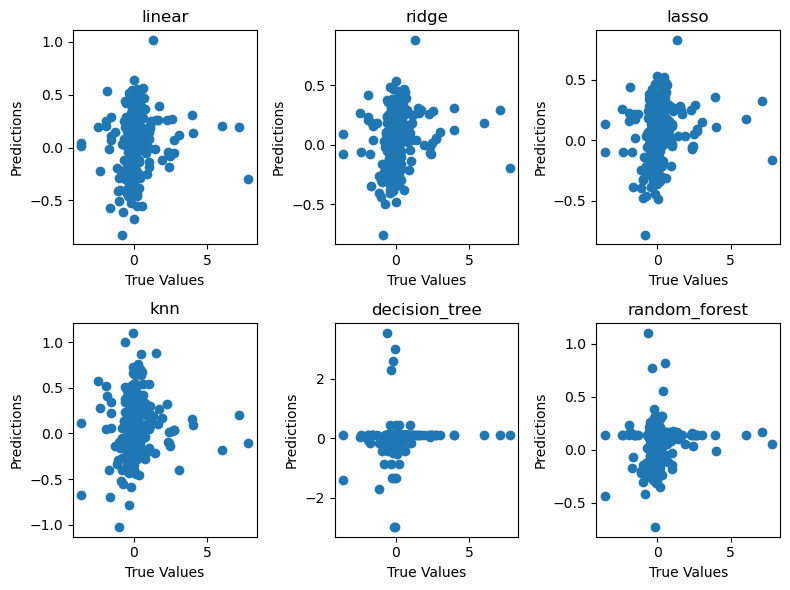

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

for i, (model_name, result) in enumerate(results.items()):
    y_pred = result['y_pred']
    row, col = i // 3, i % 3
    axs[row, col].scatter(y_test, y_pred)
    axs[row, col].set_xlabel('True Values')
    axs[row, col].set_ylabel('Predictions')
    axs[row, col].set_title(model_name)

plt.tight_layout()
plt.show()

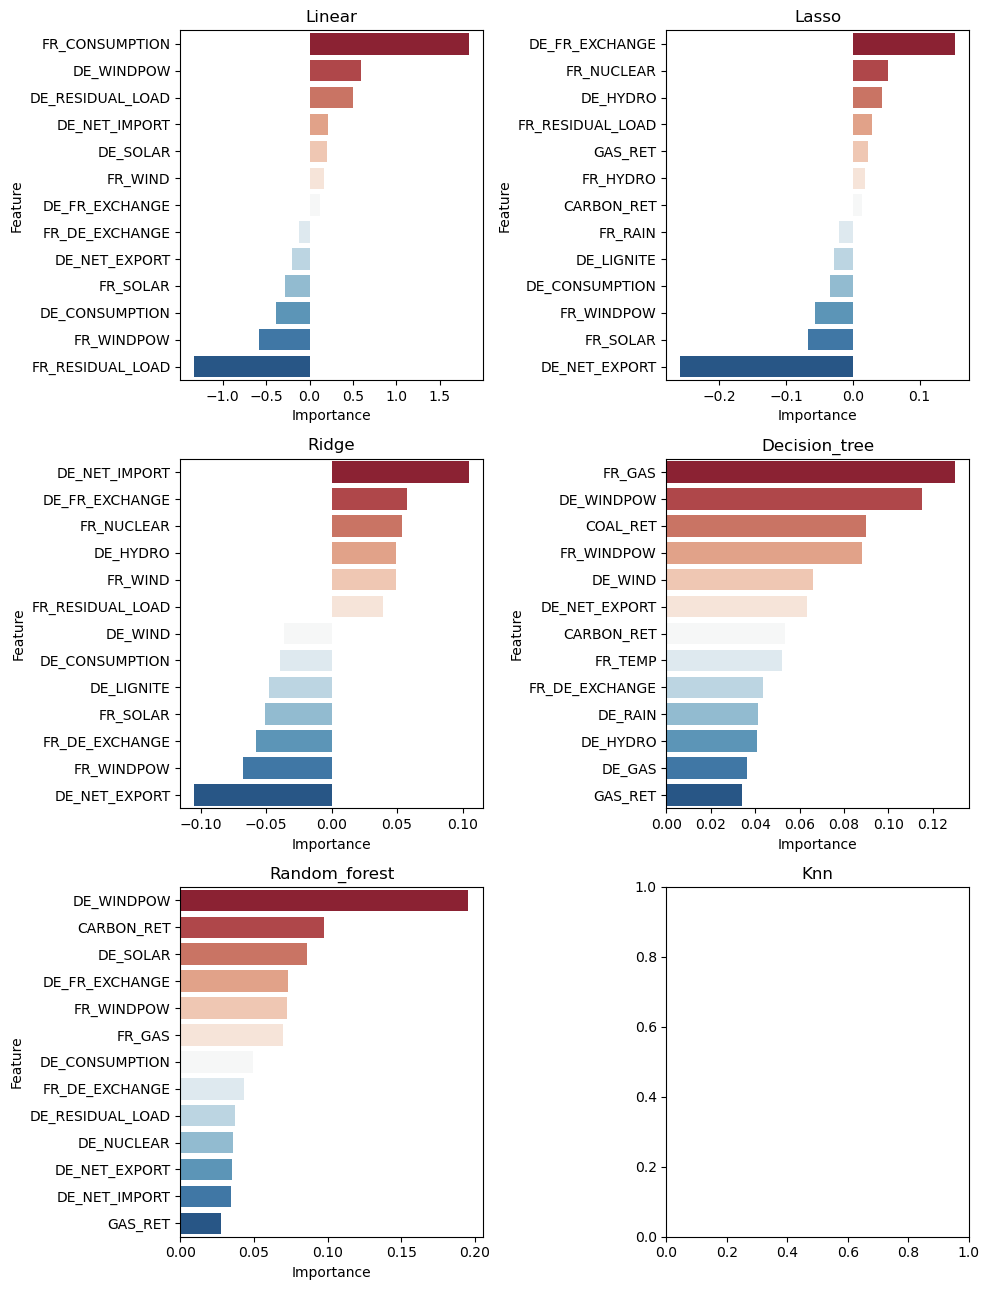

In [13]:
n_rows = 3
n_cols = 2
n = 13
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 13))
axs = axs.flatten()

def foo(ax, model_name, results):
    importances = results[model_name].get('feature_importances', None)
    if importances :
        importances_df = pd.DataFrame.from_dict(importances, orient='index', columns=['importance'])
        importances_df = importances_df.sort_values(by='importance', key=lambda x: x.abs(), ascending=False)
        importances_df = pd.DataFrame(importances_df.head(n))
        importances_df.sort_values('importance', ascending=False, inplace=True)
        sns.barplot(data=importances_df, y=importances_df.index, x='importance', palette='RdBu', ax=ax)
        ax.set_title(f'{model_name.capitalize()}')
        ax.set_xlabel('Importance')
        ax.set_ylabel('Feature')

foo(axs[0], 'linear', results)
foo(axs[1], 'lasso', results)
foo(axs[2], 'ridge', results)
foo(axs[3], 'decision_tree', results)
foo(axs[4], 'random_forest', results)
axs[5].set_title('Knn')

plt.tight_layout()
plt.show()